## daily data updates for the helioforecast.space website of science data

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'

need to copy kernel files manually to the kernel paths


In [1]:
# https://github.com/cmoestl/heliocats  data_update_web.py

# for updating data every day on the servers

import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib
import pandas as pd
from datetime import datetime, timedelta
import spiceypy
import glob
import urllib.request
import json


from heliocats import data as hd
from heliocats import plot as hp


##### check for system type
#server
if sys.platform == 'linux': 
    print('system is linux')
    matplotlib.use('Agg') 
#mac
if sys.platform =='darwin':  
    print('system is mac')
    #for testing
    #%matplotlib inline     
    matplotlib.use('Agg') 



################################################ CHECK  ##############################################
os.system('jupyter nbconvert --to script data_update_web_science.ipynb')   

#switches
debug_mode=0


#switches
get_wind=1
get_bepi=1
get_stereoa=0
get_solo=0
get_psp=0

####################################################################################################################


#test execution times
t0all = time.time()

/Users/chris/python/miniconda3/envs/helio4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


system is mac


[NbConvertApp] Converting notebook data_update_web_science.ipynb to script
[NbConvertApp] Writing 18722 bytes to data_update_web_science.py


### Configure paths depending on server or local machine


In [2]:
if sys.platform == 'linux': 
    
    from config_server import data_path
    from config_server import noaa_path
    from config_server import wind_path
    from config_server import solo_path    
    from config_server import stereoa_path
    from config_server import kernels_path
    from config_server import data_path_ml
    
if sys.platform =='darwin':  

    from config_local import data_path
    from config_local import noaa_path
    from config_local import wind_path
    from config_local import solo_path    
    from config_local import stereoa_path
    from config_local import kernels_path 
    from config_local import data_path_ml

print(' ')
print('------ PATHS ')

print(data_path)
print(noaa_path)
print(wind_path)
print(solo_path)
print(stereoa_path)
print(kernels_path)
#print(data_path_ml)


plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)



########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'solo') == False: os.mkdir(plot_path+'solo')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(solo_path) == False: os.mkdir(solo_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/solo/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/kernels/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/


In [3]:
#EMMA SOLO

def download_solomag_1min(start_timestamp, path=f'{solo_path}'+'mag/level2/'):
    start = start_timestamp.date()
    end = datetime.utcnow().date() + timedelta(days=1)
    while start < end:
        date_str = f'{start.year}{start.month:02}{start.day:02}'
        data_item_id = f'solo_L2_mag-rtn-normal-1-minute_{date_str}'
        if os.path.isfile(f"{path}{data_item_id}.cdf") == True:
            print(f'{data_item_id}.cdf has already been downloaded.')
            start += timedelta(days=1)
        else:
            try:
                data_url = f'http://soar.esac.esa.int/soar-sl-tap/data?retrieval_type=PRODUCT&data_item_id={data_item_id}&product_type=SCIENCE'
                urllib.request.urlretrieve(data_url, f"{path}{data_item_id}.cdf")
                print(f'Successfully downloaded {data_item_id}.cdf')
                start += timedelta(days=1)
            except Exception as e:
                print('ERROR', e, data_item_id)
                start += timedelta(days=1)


def download_soloplas(start_timestamp, path=f'{solo_path}'+'swa/level2/'):
    start = start_timestamp.date()
    end = datetime.utcnow().date() + timedelta(days=1)
    while start < end:
        date_str = f'{start.year}{start.month:02}{start.day:02}'
        data_item_id = f'solo_L2_swa-pas-grnd-mom_{date_str}'
        if os.path.isfile(f"{path}{data_item_id}.cdf") == True:
            print(f'{data_item_id}.cdf has already been downloaded.')
            start += timedelta(days=1)
        else:
            try:
                data_url = f'http://soar.esac.esa.int/soar-sl-tap/data?retrieval_type=PRODUCT&data_item_id={data_item_id}&product_type=SCIENCE'
                urllib.request.urlretrieve(data_url, f"{path}{data_item_id}.cdf")
                print(f'Successfully downloaded {data_item_id}.cdf')
                start += timedelta(days=1)
            except Exception as e:
                print('ERROR', e, data_item_id)
                start += timedelta(days=1)


"""
LOAD IN SOLO DATA FUNCTIONS: from datapath, and arranges into large dataframes for timerange
"""


def get_solomag(fp):
    """raw = rtn"""
    try:
        cdf = cdflib.CDF(fp)
        t1 = cdflib.cdfepoch.to_datetime(cdf.varget('EPOCH'))
        df = pd.DataFrame(t1, columns=['time'])
        bx, by, bz = cdf['B_RTN'][:].T
        df['bx'] = bx
        df['by'] = by
        df['bz'] = bz
        df['bt'] = np.linalg.norm(df[['bx', 'by', 'bz']], axis=1)
    except Exception as e:
        print('ERROR:', e, fp)
        df = None
    return df


def get_soloplas(fp):
    """raw = rtn"""
    try:
        cdf = cdflib.CDF(fp)
        t1 = cdflib.cdfepoch.to_datetime(cdf.varget('EPOCH'))
        df = pd.DataFrame(t1, columns=['time'])
        df['np'] = cdf['N']
        df['tp'] = cdf['T']
        vx, vy, vz = cdf['V_RTN'][:].T
        df['vx'] = vx
        df['vy'] = vy
        df['vz'] = vz
        df['vt'] = np.linalg.norm(df[['vx', 'vy', 'vz']], axis=1)
    except Exception as e:
        print('ERROR:', e, fp)
        df = None
    return df


def get_solomag_range_1min(start_timestamp, end_timestamp=datetime.utcnow(), path=f'{solo_path}'+'mag/level2/'):
    """Pass two datetime objects and grab .cdf files between dates, from
    directory given."""
    df = None
    start = start_timestamp.date()
    end = end_timestamp.date() + timedelta(days=1)
    while start < end:
        date_str = f'{start.year}{start.month:02}{start.day:02}'
        fn = f'{path}solo_L2_mag-rtn-normal-1-minute_{date_str}.cdf'
        _df = get_solomag(fn)
        if _df is not None:
            if df is None:
                df = _df.copy(deep=True)
            else:
                df = pd.concat([df, _df])
        start += timedelta(days=1)
    return df


def get_soloplas_range(start_timestamp, end_timestamp=datetime.utcnow(), path=f'{solo_path}'+'swa/level2/'):
    """Pass two datetime objects and grab .cdf files between dates, from
    directory given."""
    df = None
    start = start_timestamp.date()
    end = end_timestamp.date() + timedelta(days=1)
    while start < end:
        date_str = f'{start.year}{start.month:02}{start.day:02}'
        fn = f'{path}solo_L2_swa-pas-grnd-mom_{date_str}.cdf'
        _df = get_soloplas(fn)
        if _df is not None:
            if df is None:
                df = _df.copy(deep=True)
            else:
                df = pd.concat([df, _df])
        start += timedelta(days=1)
    return df


"""
SOLO POSITION FUNCTIONS: coord maths, furnish kernels, and call position for each timestamp
"""

def cart2sphere(x,y,z):
    r = np.sqrt(x**2+ y**2 + z**2) /1.495978707E8         
    theta = np.arctan2(z,np.sqrt(x**2+ y**2)) * 360 / 2 / np.pi
    phi = np.arctan2(y,x) * 360 / 2 / np.pi                   
    return (r, theta, phi)


#http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/fk/ for solo_ANC_soc-sci-fk_V08.tf
#http://spiftp.esac.esa.int/data/SPICE/SOLAR-ORBITER/kernels/spk/ for solo orbit .bsp

def solo_furnish():
    """Main"""
    solo_path = kernels_path+'solo/'
    generic_path = kernels_path+'generic/'
    solo_kernels = os.listdir(solo_path)
    generic_kernels = os.listdir(generic_path)
    print(solo_kernels)
    print(generic_kernels)
    for kernel in solo_kernels:
        spiceypy.furnsh(os.path.join(solo_path, kernel))
    for kernel in generic_kernels:
        spiceypy.furnsh(os.path.join(generic_path, kernel))


def get_solo_pos(t):
    if spiceypy.ktotal('ALL') < 1:
        solo_furnish()
    pos = spiceypy.spkpos("SOLAR ORBITER", spiceypy.datetime2et(t), "HEEQ", "NONE", "SUN")[0]
    r, lat, lon = cart2sphere(pos[0],pos[1],pos[2])
    position = t, pos[0], pos[1], pos[2], r, lat, lon
    return position


def get_solo_positions(time_series):
    positions = []
    for t in time_series:
        position = get_solo_pos(t)
        positions.append(position)
    df_positions = pd.DataFrame(positions, columns=['time', 'x', 'y', 'z', 'r', 'lat', 'lon'])
    return df_positions


"""
FINAL FUNCTION TO CREATE PICKLE FILE: uses all above functions to create pickle file of 
data from input timestamp to now. 
Can be read in to DataFrame using:
obj = pd.read_pickle('solo_rtn.p')
df = pd.DataFrame.from_records(obj)
"""


def create_solo_pkl(start_timestamp,data_save_path):
    
    #download solo mag and plasma data up to now 
    download_solomag_1min(start_timestamp)
    download_soloplas(start_timestamp)

    #load in mag data to DataFrame and resample, create empty mag and resampled DataFrame if no data
    # if empty, drop time column ready for concat
    df_mag = get_solomag_range_1min(start_timestamp)
    if df_mag is None:
        print(f'SolO MAG data is empty for this timerange')
        df_mag = pd.DataFrame({'time':[], 'bt':[], 'bx':[], 'by':[], 'bz':[]})
        mag_rdf = df_mag.drop(columns=['time'])
    else:
        mag_rdf = df_mag.set_index('time').resample('1min').mean().reset_index(drop=False)
        mag_rdf.set_index(pd.to_datetime(mag_rdf['time']), inplace=True)
        
    #load in plasma data to DataFrame and resample, create empty plasma and resampled DataFrame if no data
    #only drop time column if MAG DataFrame is not empty
    df_plas = get_soloplas_range(start_timestamp)
    if df_plas is None:
        print(f'SolO SWA data is empty for this timerange')
        df_plas = pd.DataFrame({'time':[], 'vt':[], 'vx':[], 'vy':[], 'vz':[], 'np':[], 'tp':[]})
        plas_rdf = df_plas
    else:
        plas_rdf = df_plas.set_index('time').resample('1min').mean().reset_index(drop=False)
        plas_rdf.set_index(pd.to_datetime(plas_rdf['time']), inplace=True)
        if mag_rdf.shape[0] != 0:
            plas_rdf = plas_rdf.drop(columns=['time'])

    #need to combine mag and plasma dfs to get complete set of timestamps for position calculation
    magplas_rdf = pd.concat([mag_rdf, plas_rdf], axis=1)
    #some timestamps may be NaT so after joining, drop time column and reinstate from combined index col
    magplas_rdf = magplas_rdf.drop(columns=['time'])
    magplas_rdf['time'] = magplas_rdf.index
     
    #get solo positions for corresponding timestamps
    solo_pos = get_solo_positions(magplas_rdf['time'])
    solo_pos.set_index(pd.to_datetime(solo_pos['time']), inplace=True)
    solo_pos = solo_pos.drop(columns=['time'])

    #produce final combined DataFrame with correct ordering of columns 
    comb_df = pd.concat([magplas_rdf, solo_pos], axis=1)

    #produce recarray with correct datatypes
    time_stamps = comb_df['time']
    dt_lst= [element.to_pydatetime() for element in list(time_stamps)] #extract timestamps in datetime.datetime format

    solo=np.zeros(len(dt_lst),dtype=[('time',object),('bx', float),('by', float),('bz', float),('bt', float),\
                ('vx', float),('vy', float),('vz', float),('vt', float),('np', float),('tp', float),\
                ('x', float),('y', float),('z', float), ('r', float),('lat', float),('lon', float)])
    solo = solo.view(np.recarray) 

    solo.time=dt_lst
    solo.bx=comb_df['bx']
    solo.by=comb_df['by']
    solo.bz=comb_df['bz']
    solo.bt=comb_df['bt']
    solo.vx=comb_df['vx']
    solo.vy=comb_df['vy']
    solo.vz=comb_df['vz']
    solo.vt=comb_df['vt']
    solo.np=comb_df['np']
    solo.tp=comb_df['tp']
    solo.x=comb_df['x']
    solo.y=comb_df['y']
    solo.z=comb_df['z']
    solo.r=comb_df['r']
    solo.lat=comb_df['lat']
    solo.lon=comb_df['lon']
    
    #dump to pickle file 
    solo.dump(data_save_path+'solo_rtn.p')
   

In [4]:
solo_furnish()

get_solo_pos(datetime(2022,12,25))

import warnings
warnings.filterwarnings("ignore")
create_solo_pkl(datetime(2022, 12, 25),data_path)


['.DS_Store', 'solo_ANC_soc-sci-fk_V08.tf', 'solo_ANC_soc-orbit_20200210-20301120_L011_V1_00200_V01.bsp']
['heliospheric_v004u.tf', 'naif0012.tls', 'pck00010.tpc', 'de430.bsp']


(datetime.datetime(2022, 12, 25, 0, 0),
 130919302.97878873,
 -45807389.502378285,
 10769170.316259407,
 0.9299545099873634,
 4.439687998000994,
 -19.284444779691697)

In [8]:
solo=pickle.load(open(data_path+'solo_rtn.p', "rb"))

In [9]:
solo

rec.array([(datetime.datetime(2022, 12, 25, 0, 0), 6.52396441, -2.67612195, -1.97809017, 7.32369995, 399.88031006,  14.64120388,   1.50598347, 400.18377686,  0.91684353,  7.66995573, 1.30919303e+08, -45807389.50237828, 10769170.31625941, 0.92995451,  4.439688  , -19.28444478),
           (datetime.datetime(2022, 12, 25, 0, 1), 6.62362051, -2.51848197, -1.93028295, 7.34446001, 398.82388306,  13.67903709,  -2.85913301, 399.23464966,  0.89207149,  7.05335903, 1.30919458e+08, -45807893.26922041, 10769045.100176  , 0.92995653,  4.43962663, -19.28462011),
           (datetime.datetime(2022, 12, 25, 0, 2), 6.54716873, -2.75747132, -2.11899948, 7.41344881, 403.80297852,  14.87091923,   8.35956192, 404.21951294,  0.93187553,  6.79419899, 1.30919612e+08, -45808397.03887697, 10768919.88218156, 0.92995854,  4.43956525, -19.28479543),
           ...,
           (datetime.datetime(2023, 3, 31, 23, 57),        nan,         nan,         nan,        nan, 552.36749268, -53.08939743, -44.02882385, 557.08

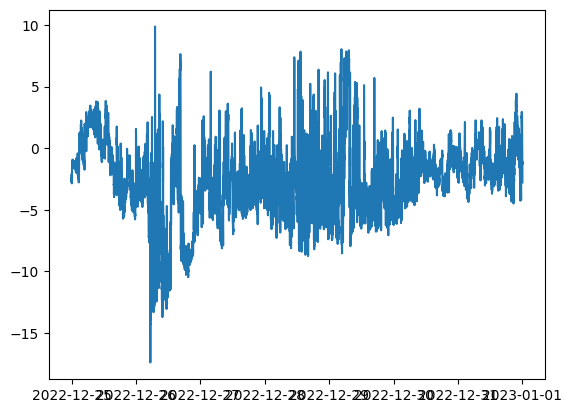

In [24]:
%matplotlib inline
plt.plot(solo.time,solo.by)


### Wind data

In [3]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 
    
print(' ')
print('------ download Wind data ')

#download data for current year only    
if get_wind > 0:
    hd.wind_download_ascii(start_year=datetime.datetime.utcnow().year, wind_path=wind_path) 
else:
    print('Wind data NOT downloaded, turn on switch')  

    
    
    
#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2022, 12, 1)
#start=datetime.datetime(2022, 12, 1)
#end=datetime.datetime.utcnow()

#hd.save_wind_data_ascii(data_path,filewin,start,end,coord='HEEQ')
#[win,winh]=pickle.load(open(data_path+filewin, "rb"))
#start=win.time[-1]-datetime.timedelta(days=365)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path+'wind/',now=True)


#on linux
#print('download new Wind data files without overwriting existing files')

#on mac for testing
#wind_data_path='/Users/chris/python/data/wind/wind_mfi_k0'
#os.system('curl -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_k0/2020/*.cdf"')



#wind_data_path='/perm/aswo/data/wind/wind_mfi_k0'
#print(wind_data_path)
#os.system('wget -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/mfi/mfi_k0/2020/*.cdf"')
#wind_data_path='/nas/helio/data/heliosat/data/wind_swe_h1'
#os.system('wget -nc --directory-prefix='+wind_data_path+' "ftps://spdf.gsfc.nasa.gov/pub/data/wind/swe/swe_h1/2020/*.cdf"')

#filewin="wind_2018_now_gse.p" 
##xstart=datetime.datetime(2018, 1, 1)
#end=datetime.datetime.utcnow()
#if get_new_data: hd.save_wind_data(data_path,filewin,start,end,heeq=False)
#[win,hwin]=pickle.load(open(data_path+filewin, "rb" ) )  

#filewin="wind_2018_now_heeq.p" 
#start=datetime.datetime(2018, 1, 1)
#end=datetime.datetime.utcnow()
#if get_new_data: hd.save_wind_data(data_path,filewin,start,end,heeq=True)

#start=win.time[-1]-datetime.timedelta(days=100)
#end=datetime.datetime.utcnow()         
#hp.plot_insitu_update(win, start, end,'Wind',plot_path,now=True)

 
------ download Wind data 


TypeError: wind_download_ascii() got an unexpected keyword argument 'start_year'

### BepiColombo

In [ ]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ download BepiColombo data ')

#if get_bepi >0: 
#    hd.download_stereoa_science_merged()

### STEREO-A science data

In [19]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ download STEREO-A science data ')

if get_stereoa >0: 
    hd.download_stereoa_science_merged()

 
------ download STEREO-A science data 


### Parker Solar Probe


In [5]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ download PSP data ')

#if get_psp >0: 
#    hd.download_stereoa_science_merged()


################################# PSP data update

################################## USE THIS ################################
# old
# load PSP data from server on linux command line onto leo server
# go to heliosat directory /nas/helio/data/heliosat/data/psp_fields_l2
# wget -nc "ftps://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2019/*.cdf"
# wget -nc "ftps://spdf.gsfc.nasa.gov/pub/data/psp/fields/l2/mag_rtn_1min/2020/*.cdf"
#  /nas/helio/data/heliosat/data/psp_spc_l3
# wget -nc "ftps://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2019/*.cdf"
# wget -nc "ftps://spdf.gsfc.nasa.gov/pub/data/psp/sweap/spc/l3/l3i/2020/*.cdf"
#new
#use beginning of icmecat.ipynb
############################################################################

# print('load PSP data') #from heliosat, converted to SCEQ similar to STEREO-A/B
#set time there
#change date in hd.save_psp_data
#filepsp='psp_2018_2020_nov_rtn.p'
#hd.save_psp_data(data_path,filepsp, sceq=False)   

#filepsp='psp_2018_2020_sceq.p'
#hd.save_psp_data(data_path,filepsp, sceq=True)   z

 
------ download PSP data 


### Solar Orbiter


In [15]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ download Solar Orbiter data ')

#if get_solo >0: 
#    hd.download_stereoa_science_merged()

 
------ download Solar Orbiter data 


### BepiColombo

In [10]:
if debug_mode > 0: 
    importlib.reload(hd) 
    importlib.reload(hp) 

print(' ')
print('------ download BepiColombo data ')

#if get_bepi >0: 
#    hd.download_stereoa_science_merged()

 
------ download BepiColombo data 


In [9]:
#sys.exit()

In [16]:


############### write header file for daily updates
#text = open('/nas/helio/data/insitu_python/data_update_headers.txt', 'w')
#text.write('Contains headers for the data files which are updated in real time.'+'\n \n')
#text.write('File creation date:  '+datetime.datetime.utcnow().strftime("%Y-%b-%d %H:%M") +' \n \n')


#text.write('NOAA real time solar wind: '+filenoaa+'\n \n'+ hnoaa+' \n \n')
#text.write('load with: >> [noaa,hnoaa]=pickle.load(open("'+data_path+filenoaa+'", "rb"))') 
#text.write(' \n \n \n \n')

#text.write('STEREO-A beacon: '+filesta_sceq+'\n \n'+ hsta+' \n \n')
#text.write('load with: >> [sta,hsta]=pickle.load(open("'+data_path+filesta+'", "rb"))') 
#text.write(' \n \n \n \n')

#text.write('Wind: '+filewin+'\n \n'+ hwin+' \n \n')
#text.write('load with: >> [win,hwin]=pickle.load(open("'+data_path+filewin+'", "rb" ))') 
#text.write(' \n \n \n \n')


#text.write('OMNI2: '+fileomni+'\n \n'+ ho+' \n \n')
#text.write('load with: >> [o,ho]=pickle.load(open("'+data_path+fileomni+'", "rb" ))') 
#text.write(' \n \n \n \n')

#text.close()